In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
source_embeddings = 399
batch_size = 32
indices = np.random.choice(source_embeddings, batch_size, replace=False)

In [4]:
indices

array([292, 373, 143, 381, 291, 309, 321, 397,  72, 120,  42,  93, 339,
       166,  36, 299, 368, 312, 365, 141, 301,  65, 285, 171, 254, 253,
       224, 294,  20, 162,  78, 269])

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:

from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

df = pd.read_csv("/content/drive/My Drive/fer2013.csv")
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
INTERESTED_LABELS = [3, 4]
df = df[df.emotion.isin(INTERESTED_LABELS)]

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(15066, 2)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12052, 48, 48, 1), (3014, 48, 48, 1), (12052, 2), (3014, 2))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

In [ ]:
def build_net(optim):
            net = Sequential(name='DCNN')

            net.add(Conv2D(filters=256,kernel_size=(5,5),input_shape=(img_width, img_height, img_depth),activation='elu',
                           padding='same',kernel_initializer='he_normal', name='conv2d_1'))
            net.add(BatchNormalization(name='batchnorm_1'))
            net.add(Conv2D(filters=128,kernel_size=(5,5),activation='elu',padding='same',kernel_initializer='he_normal',
                        name='conv2d_2'))
            net.add(BatchNormalization(name='batchnorm_2'))
            net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
            net.add(Dropout(0.4, name='dropout_1'))
            net.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',
                        name='conv2d_3'))
            net.add(BatchNormalization(name='batchnorm_3'))
            net.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',
                        name='conv2d_4'))
            net.add(BatchNormalization(name='batchnorm_4'))
            net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
            net.add(Dropout(0.4, name='dropout_2'))
            net.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',
                        name='conv2d_5'))
            net.add(BatchNormalization(name='batchnorm_5'))
            net.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',
                        name='conv2d_6'))
            net.add(BatchNormalization(name='batchnorm_6'))
            net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
            net.add(Dropout(0.5, name='dropout_3'))
            net.add(Flatten(name='flatten'))
            net.add(Dense(128,activation='elu',kernel_initializer='he_normal',name='dense_1'))
            net.add(BatchNormalization(name='batchnorm_7'))
            net.add(Dropout(0.6, name='dropout_4'))
            net.add(Dense(num_classes,activation='softmax',name='out_layer'))

            net.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

            net.summary()
            
            return net



In [ ]:

early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=10,verbose=1,
    restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1)

callbacks = [early_stopping,lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,width_shift_range=0.15,height_shift_range=0.15,
    shear_range=0.15,zoom_range=0.15,horizontal_flip=True)
train_datagen.fit(X_train)

In [ ]:
batch_size = 64 
epochs = 75
optims = [optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
          ,optimizers.Adam(0.001)]

model = build_net(optims[1]) 
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,epochs=epochs,callbacks=callbacks)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 256)       6656      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       819328    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 128)       512       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584 

In [ ]:
model.save("final_model.h5")

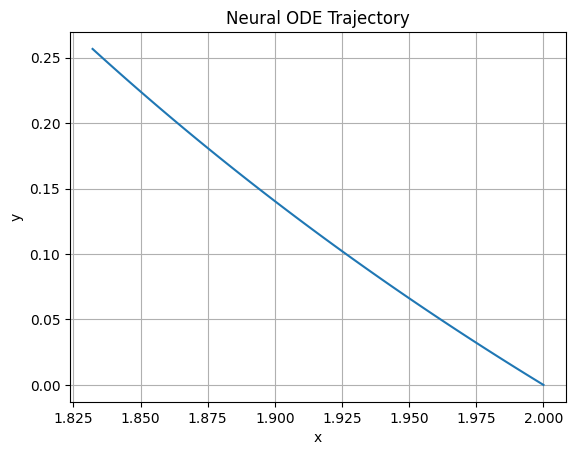

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Định nghĩa hàm đạo hàm: dy/dt = f(y, t)
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)

# Hàm dự đoán bằng Neural ODE
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, y0, t):
        return odeint(self.odefunc, y0, t)

# Khởi tạo mô hình
func = ODEFunc()
odeblock = ODEBlock(func)

# Dữ liệu ban đầu: y0 = [x0, y0]
y0 = torch.tensor([[2.0, 0.0]])
t = torch.linspace(0., 2., 100)  # thời gian từ 0 đến 2

# Dự đoán
with torch.no_grad():
    y_pred = odeblock(y0, t)

# Vẽ kết quả
y_pred = y_pred.squeeze().numpy()
plt.plot(y_pred[:, 0], y_pred[:, 1])
plt.title("Neural ODE Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()
